<a href="https://colab.research.google.com/github/ngohuy1811/AIO---Module-2/blob/main/Enhanced_Text_image_retrieval_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install chromadb
!pip install open-clip-torch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.3/584.3 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.8/273.8 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 87.4 MB/s eta 0:00:00


In [6]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction

In [7]:
!gdown 1msLVo0g0LFmL9-qZ73vq9YEVZwbzOePF
!unzip /content/data.zip -d /content/

Downloading...
From (original): https://drive.google.com/uc?id=1msLVo0g0LFmL9-qZ73vq9YEVZwbzOePF
From (redirected): https://drive.google.com/uc?id=1msLVo0g0LFmL9-qZ73vq9YEVZwbzOePF&confirm=t&uuid=40d080ec-9e2d-49df-93ac-c695b94d82b0
To: /content/data.zip
100% 76.1M/76.1M [00:00<00:00, 170MB/s]
Archive:  /content/data.zip
   creating: /content/data/
   creating: /content/data/.ipynb_checkpoints/
   creating: /content/data/test/
   creating: /content/data/test/American_egret/
  inflating: /content/data/test/American_egret/n02009912_2473.JPEG  
   creating: /content/data/test/Doberman/
  inflating: /content/data/test/Doberman/n02107142_52285.JPEG  
   creating: /content/data/test/Rhodesian_ridgeback/
  inflating: /content/data/test/Rhodesian_ridgeback/n02087394_18723.JPEG  
   creating: /content/data/test/African_crocodile/
  inflating: /content/data/test/African_crocodile/n01697457_18534.JPEG  
   creating: /content/data/test/Lakeland_terrier/
  inflating: /content/data/test/Lakeland_ter

In [8]:
ROOT = '/content/data'
CLASS_NAME = sorted(list(os.listdir(f'{ROOT}/train')))

def read_image_from_path(path,size):
  im = Image.open(path).convert('RGB').resize(size) #All image must have the same size
  return np.array(im)

def folder_to_images(folder, size):
  #List all the paths for images belonging to a specific class
  list_dir = [folder +'/'+ name for name in os.listdir(folder)]

  #Load all images belonging to a specific class and return them with their corresponding file paths
  images_np = np.zeros(shape=(len(list_dir),*size, 3))
  images_path = []
  for i, path in enumerate(list_dir):
    images_np[i] = read_image_from_path(path, size)
    images_path.append(path)
  images_path = np.array(images_path)
  return images_np, images_path

#Hàm trả về kết quả ảnh trên matplotlib
def plot_results(querquery_pathy, ls_path_score, reverse):
    fig = plt.figure(figsize=(15, 9))
    fig.add_subplot(2, 3, 1)
    plt.imshow(read_image_from_path(querquery_pathy, size=(448,448)))
    plt.title(f"Query Image: {querquery_pathy.split('/')[2]}", fontsize=16)
    plt.axis("off")
    for i, path in enumerate(sorted(ls_path_score, key=lambda x : x[1], reverse=reverse)[:5], 2):
        fig.add_subplot(2, 3, i)
        plt.imshow(read_image_from_path(path[0], size=(448,448)))
        plt.title(f"Top {i-1}: {path[0].split('/')[2]}", fontsize=16)
        plt.axis("off")
    plt.show()

In [9]:
#Convert image to a feature vector
embedding_function = OpenCLIPEmbeddingFunction()

def get_single_image_embedding(image):
  embedding = embedding_function._encode_image(image=image)
  return np.array(embedding)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

#**L1 Distance**

In [10]:
#Tao ham tinh L1
def absolute_difference(query, data):
  axis_batch_size = tuple(range(1,len(data.shape)))
  return np.sum(np.abs(data - query), axis = axis_batch_size)

In [11]:
#Hàm trả ảnh query và ls_path_score tích hợp embedding
def get_l1_score(root_img_path, query_path, size):
  query = read_image_from_path(query_path, size)
  query_embedding = get_single_image_embedding(query)
  ls_path_score = []
  for folder in os.listdir(root_img_path):
    if folder in CLASS_NAME:
      path = root_img_path + folder
      images_np, images_path = folder_to_images(path, size)
      embedding_list = []
      for idx_img in range(images_np.shape[0]):
        embedding = get_single_image_embedding(images_np[idx_img].astype(np.uint8))
        embedding_list.append(embedding)
      rates = absolute_difference(query_embedding, np.stack(embedding_list))
      ls_path_score.extend(list(zip(images_path, rates)))
  return query, ls_path_score

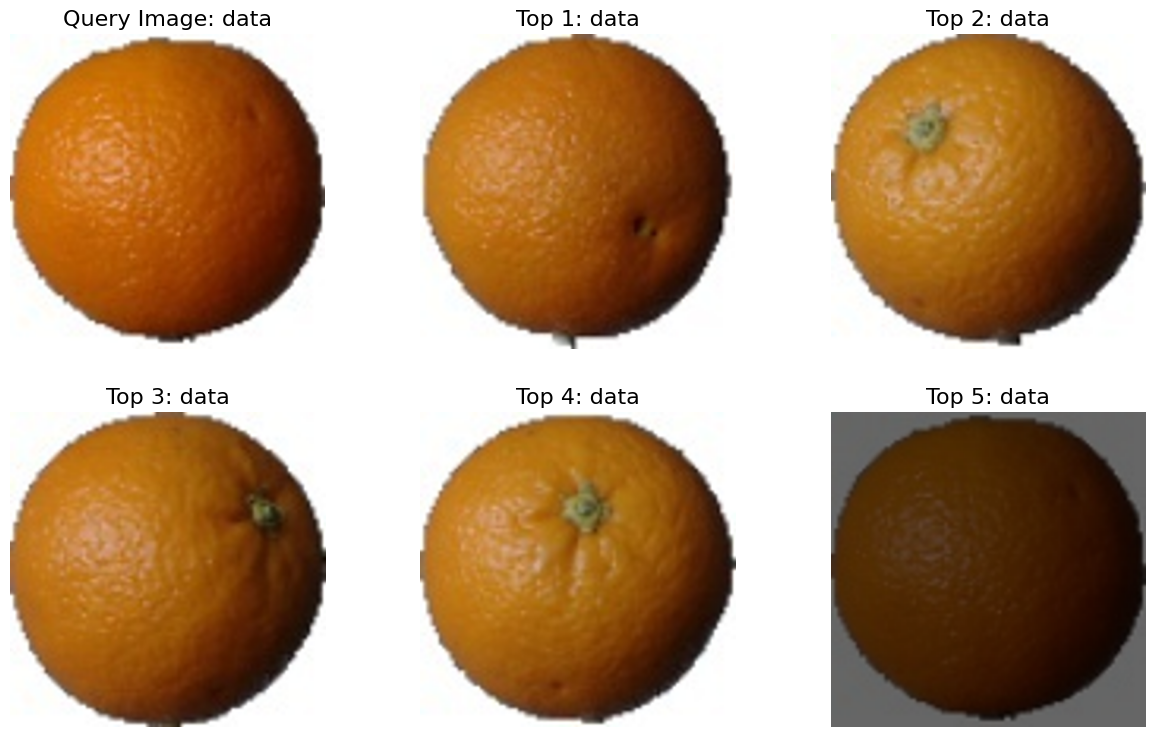

In [12]:
root_img_path = f"{ROOT}/train/"
query_path = f"{ROOT}/test/Orange_easy/0_100.jpg"
size = (448, 448)
query, ls_path_score = get_l1_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=False)

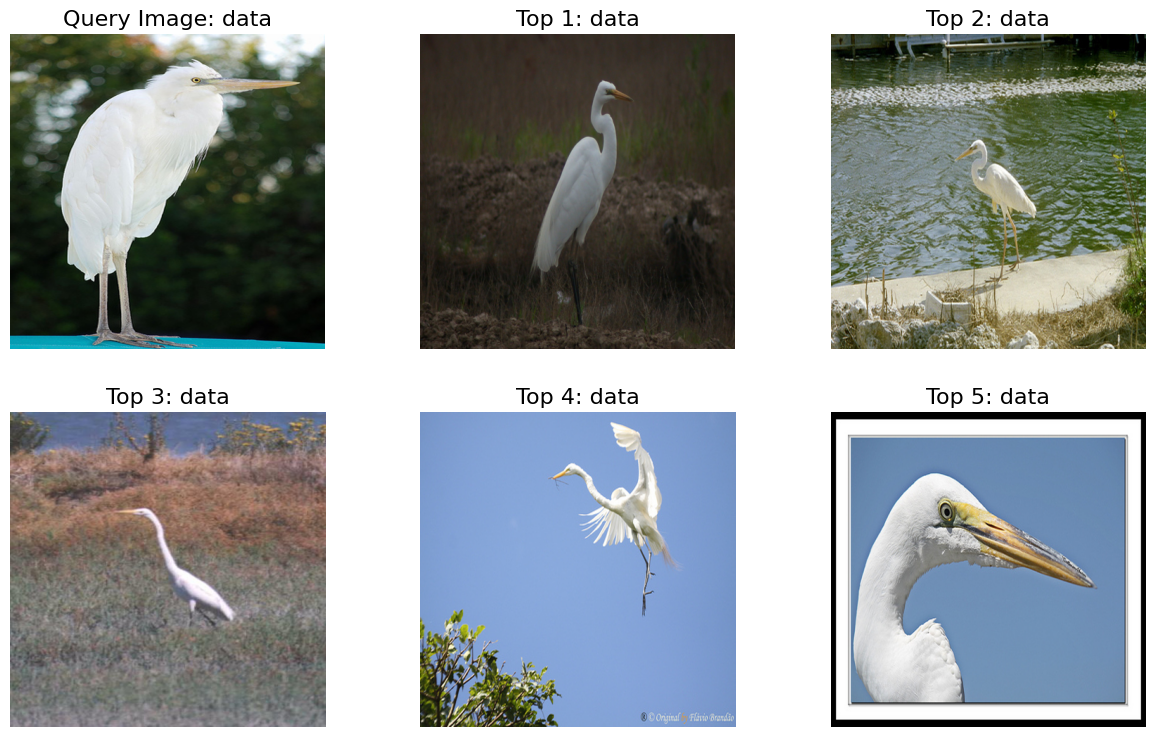

In [13]:
root_img_path = f"{ROOT}/train/"
query_path = f"{ROOT}/test/American_egret/n02009912_2473.JPEG"
size = (448, 448)
query, ls_path_score = get_l1_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=False)

# **L2 Distance**

In [14]:
#Hàm mean square difference L2
def mean_square_difference(query, data):
  axis_batch_size = tuple(range(1,len(data.shape)))
  return np.mean((data - query)**2, axis=axis_batch_size)

In [15]:
#Hàm trả ảnh query và ls_path_score tích hợp embedding
def get_l2_score(root_img_path, query_path, size):
  query = read_image_from_path(query_path, size)
  query_embedding = get_single_image_embedding(query)
  ls_path_score = []
  for folder in os.listdir(root_img_path):
    if folder in CLASS_NAME:
      path = root_img_path + folder
      images_np, images_path = folder_to_images(path, size)
      embedding_list = []
      for idx_img in range(images_np.shape[0]):
        embedding = get_single_image_embedding(images_np[idx_img].astype(np.uint8))
        embedding_list.append(embedding)
      rates = mean_square_difference(query_embedding, np.stack(embedding_list))
      ls_path_score.extend(list(zip(images_path, rates)))
  return query, ls_path_score

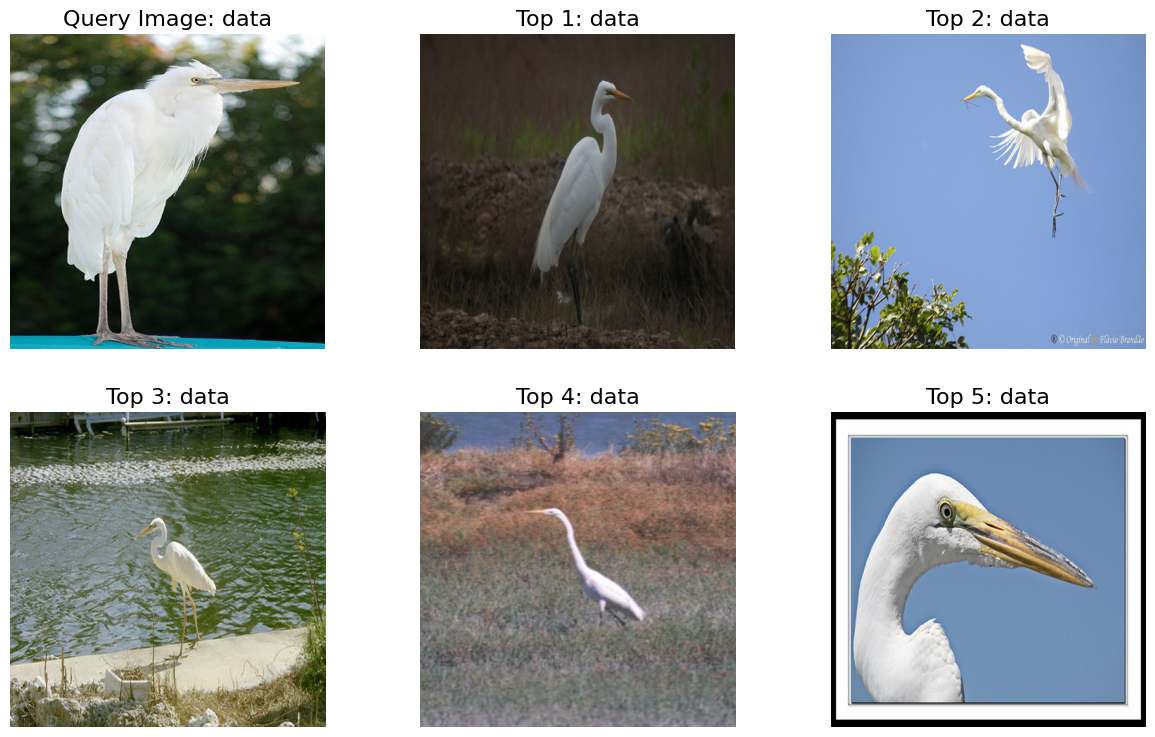

In [16]:
root_img_path = f"{ROOT}/train/"
query_path = f"{ROOT}/test/American_egret/n02009912_2473.JPEG"
size = (448, 448)
query, ls_path_score = get_l2_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=False)

# **Cosine Similarity**

In [17]:
# Tạo hàm tính cosine similarity
def cosine_similarity(query, data):
  axis_batch_size = tuple(range(1,len(data.shape)))
  query_norm = np.sqrt(np.sum(query**2))
  data_norm = np.sqrt(np.sum(data**2, axis=axis_batch_size))
  return np.sum(data*query, axis=axis_batch_size) / (query_norm*data_norm + np.finfo(float).eps)

In [18]:
#Hàm trả ảnh query và ls_path_score tích hợp embedding
def get_cosine_similarity_score(root_img_path, query_path, size):
  query = read_image_from_path(query_path, size)
  query_embedding = get_single_image_embedding(query)
  ls_path_score = []
  for folder in os.listdir(root_img_path):
    if folder in CLASS_NAME:
      path = root_img_path + folder
      images_np, images_path = folder_to_images(path, size)
      embedding_list = []
      for idx_img in range(images_np.shape[0]):
        embedding = get_single_image_embedding(images_np[idx_img].astype(np.uint8))
        embedding_list.append(embedding)
      rates = cosine_similarity(query_embedding, np.stack(embedding_list))
      ls_path_score.extend(list(zip(images_path, rates)))
  return query, ls_path_score

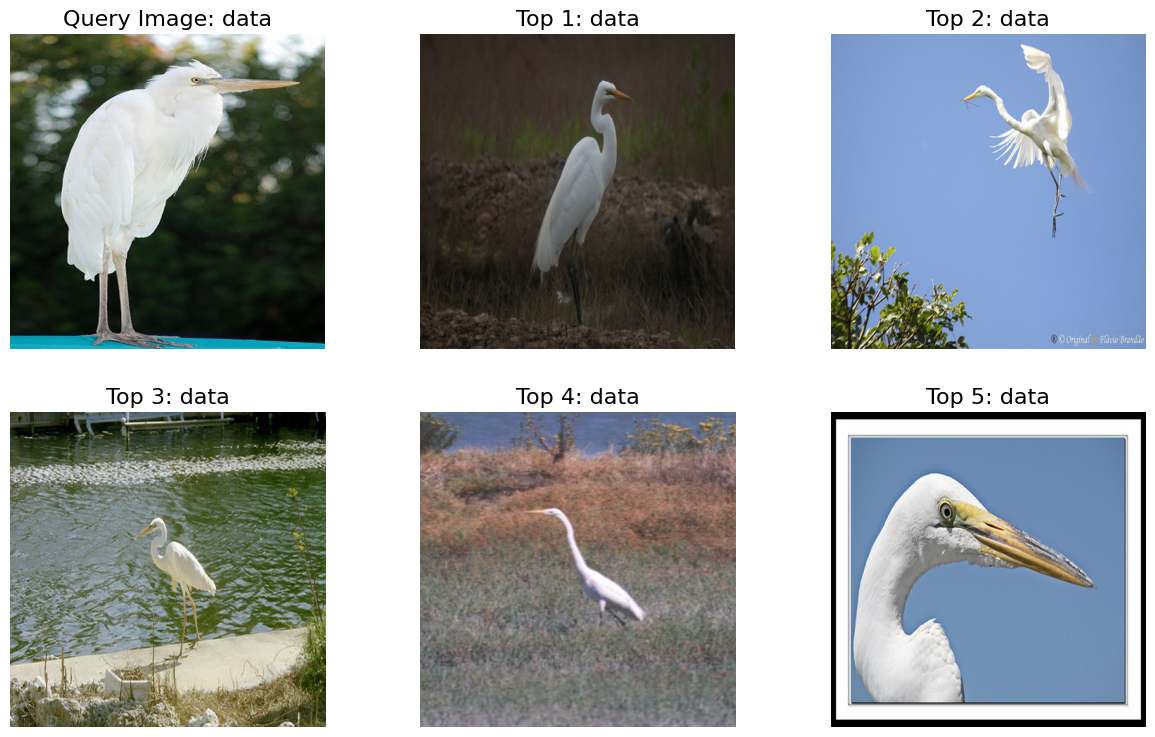

In [24]:
root_img_path = f"{ROOT}/train/"
query_path = f"{ROOT}/test/American_egret/n02009912_2473.JPEG"
size = (448, 448)
query, ls_path_score = get_cosine_similarity_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=True)

# **Correlation Coefficient**

In [21]:
# Hàm tính correlation_coefficient
def correlation_coefficient(query, data):
  axis_batch_size = tuple(range(1,len(data.shape)))
  query_mean = query - np.mean(query)
  data_mean = data - np.mean(data, axis=axis_batch_size, keepdims=True)
  query_norm = np.sqrt(np.sum(query_mean**2))
  data_norm = np.sqrt(np.sum(data_mean**2, axis=axis_batch_size))
  return np.sum(data_mean * query_mean, axis=axis_batch_size) / (query_norm*data_norm + np.finfo(float).eps)

In [22]:
#Hàm trả ảnh query và ls_path_score tích hợp embedding
def get_correlation_coefficient_score(root_img_path, query_path, size):
  query = read_image_from_path(query_path, size)
  query_embedding = get_single_image_embedding(query)
  ls_path_score = []
  for folder in os.listdir(root_img_path):
    if folder in CLASS_NAME:
      path = root_img_path + folder
      images_np, images_path = folder_to_images(path, size)
      embedding_list = []
      for idx_img in range(images_np.shape[0]):
        embedding = get_single_image_embedding(images_np[idx_img].astype(np.uint8))
        embedding_list.append(embedding)
      rates = correlation_coefficient(query_embedding, np.stack(embedding_list))
      ls_path_score.extend(list(zip(images_path, rates)))
  return query, ls_path_score

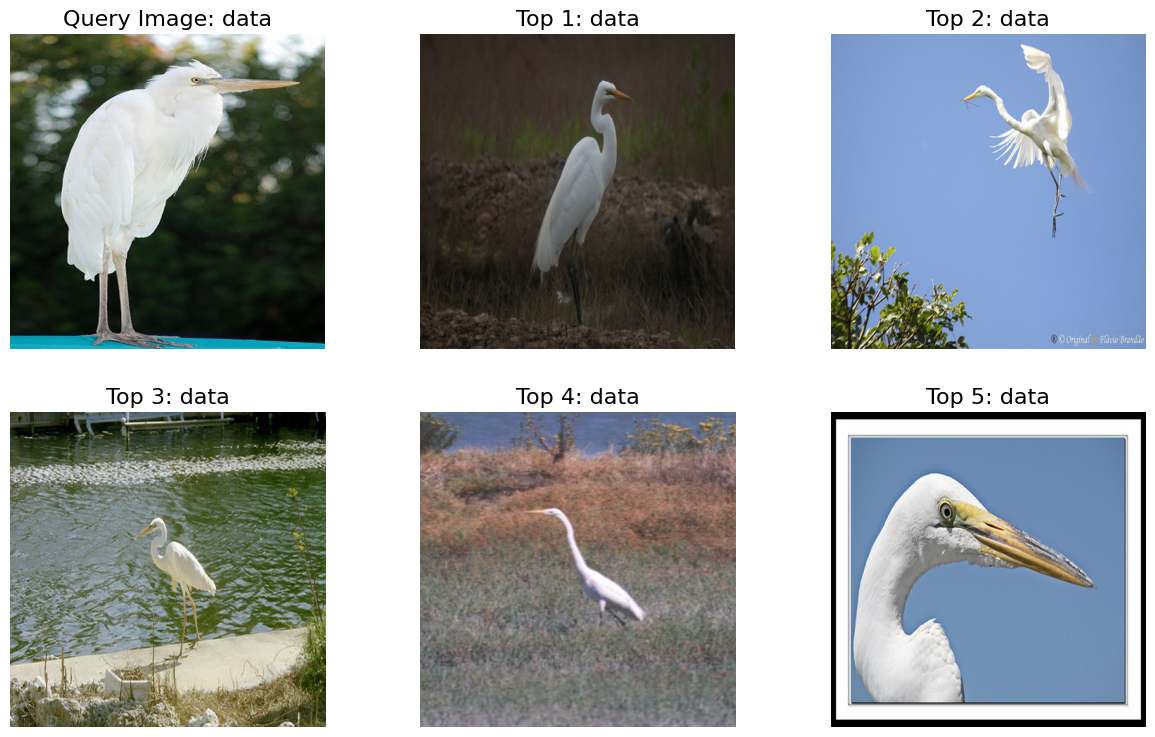

In [25]:
root_img_path = f"{ROOT}/train/"
query_path = f"{ROOT}/test/American_egret/n02009912_2473.JPEG"
size = (448, 448)
query, ls_path_score = get_correlation_coefficient_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=True)

# **Optimizing using Vector Database**

In [ ]:
#Trích xuất đường dẫn của các ảnh từ một thư mục cho trước
def get_files_path(path):
  files_path = []
  for label in CLASS_NAME:
    label_path = path + "/" + label
    filenames = os.listdir(label_path)
    for filename in filenames:
      filepath = label_path + '/' + filename
      files_path.append(filepath)

  return files_path
data_path = f'{ROOT}/train'
files_path = get_files_path(path=data_path)
